# IMDb Top 250 Movies:  Clustering Analysis

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In this notebook, we'll investigate clustering patterns in the Top 250 movie list on IMDb.  The [formula](http://www.imdb.com/help/show_leaf?votestopfaq) for choosing movies on the list is as follows: 

![](assets/IMDbformula.png)

In [1]:
import numpy as np
import time
import pandas as pd
import seaborn as sns
import re
import ast
import datetime
import calendar

from IPython.core.display import Image
from imdbpie import Imdb
from bs4 import BeautifulSoup
from urllib2 import Request, urlopen, URLError
import requests
from easymoney.money import EasyPeasy

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pylab
import plotly.plotly as py
import plotly.graph_objs as go

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA 

from scipy.spatial import distance


% matplotlib inline

In [2]:
Image(url='http://bit.ly/29OUgDA', width = 650)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;First, let's get the current (March 2017) Top 250 movies and save to file:

In [3]:
imdb = Imdb(anonymize = True, cache = True)
# top = pd.DataFrame(imdb.top_250())
# top.to_csv('./assets/top.csv', index = False, encoding = 'utf-8')

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Load Top 250 movie data from file:

In [4]:
top = pd.read_csv('./assets/top.csv')
top.head(1)

,can_rate,image,num_votes,rating,tconst,title,type,year
0,True,{u'url': u'https://images-na.ssl-images-amazon...,1789788,9.3,tt0111161,The Shawshank Redemption,feature,1994


In [5]:
top.dtypes

can_rate        bool
image         object
num_votes      int64
rating       float64
tconst        object
title         object
type          object
year           int64
dtype: object

### can_rate

In [6]:
top['can_rate'].value_counts()

True    250
Name: can_rate, dtype: int64

In [7]:
top.drop('can_rate', axis = 1, inplace = True)

### image

In [8]:
top['image'][0]

"{u'url': u'https://images-na.ssl-images-amazon.com/images/M/MV5BODU4MjU4NjIwNl5BMl5BanBnXkFtZTgwMDU2MjEyMDE@._V1_.jpg', u'width': 933, u'height': 1388}"

In [9]:
top.drop('image', axis = 1, inplace = True)

### type

In [10]:
top['type'].value_counts()

feature    250
Name: type, dtype: int64

In [11]:
top.drop('type', axis = 1, inplace = True)

### year

In [12]:
top['year'] = top['year'].astype('float')

### tconst

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We need to keep 'tconst' for now in order to do further scraping.

## Exploratory Data Analysis (EDA)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let's take a look at a histogram of year:

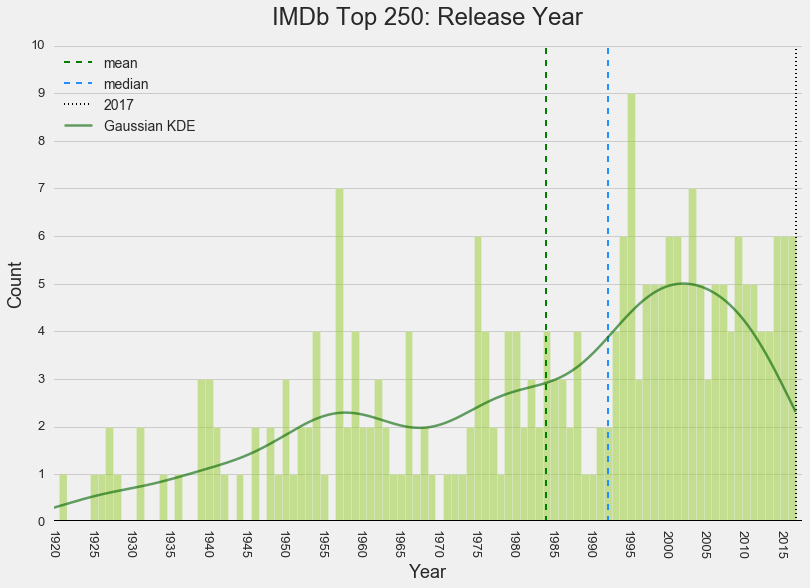

In [15]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

minyear = int(top['year'].min())
maxyear = int(top['year'].max())

df_hist = plt.hist(top['year'], color = 'yellowgreen', alpha = 0.5, bins = maxyear - minyear)
plt.axvline(top['year'].mean(), color='g', linestyle='dashed', linewidth = 2, label = 'mean')
plt.axvline(top['year'].median(), color='dodgerblue', linestyle='dashed', linewidth = 2, \
            label = 'median')
plt.axvline(maxyear, color='black', linestyle = ':', linewidth = 2, label = '2017')
plt.axhline(0, color='black')
plt.title('IMDb Top 250: Release Year', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count', fontsize = 18)
plt.yticks(range(0, 11, 1), fontsize = 13)

# x label
plt.xlabel('Year', fontsize = 18)
plt.xticks(range(1920, maxyear, 5), fontsize = 13, rotation = -90)

plt.xlim([minyear - minyear%10, maxyear + 1])
plt.ylim([0, 10.04])

density = gaussian_kde(top.loc[top['year'] <= 2016, 'year'])
xs = np.linspace(1920, top['year'].max(), 1000)
density.covariance_factor = lambda : 0.25
density._compute_covariance()
plt.plot(xs, density(xs)*1000/4, linewidth = 2.5, label = 'Gaussian KDE', \
         color = 'darkgreen', alpha = 0.6)

plt.legend(loc = 'best', fontsize = 14)

plt.grid(which = 'major', axis = 'x')

plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(NB The dip in the Gaussian kernel density estimate on the right hand side is an edge effect; number of movies per year on the Top 250 is not trending downward.)

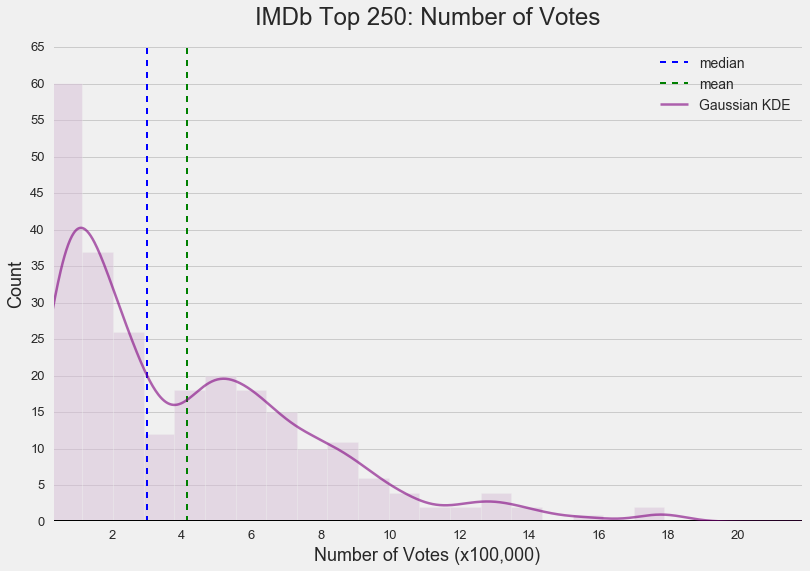

In [14]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

div = 100000

df_hist = plt.hist(top['num_votes']/div, color = 'thistle', alpha = 0.5, bins = 20)
plt.axvline(top['num_votes'].median()/div, color='b', linestyle='dashed', linewidth = 2, \
            label = 'median')
plt.axvline(top['num_votes'].mean()/div, color='g', linestyle='dashed', linewidth = 2, \
            label = 'mean')
plt.axhline(0, color='black')
plt.title('IMDb Top 250: Number of Votes', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count', fontsize = 18)
plt.yticks(range(0, 70, 5), fontsize = 13)
plt.ylim([0, 65.5])

# x label
plt.xlabel('Number of Votes (x100,000)', fontsize = 18)
plt.xticks(range(0, 22, 2), fontsize = 13)

plt.xlim([min(top['num_votes']/div), max(top['num_votes']/div) + 4])


density = gaussian_kde(top['num_votes']/div)
xs = np.linspace(top['num_votes'].min()/div, top['num_votes'].max()/div + 10, 1000)
density.covariance_factor = lambda : 0.2
density._compute_covariance()
plt.plot(xs, density(xs)*1000/4.5, linewidth = 2.5, label = 'Gaussian KDE', \
         color = 'purple', alpha = 0.6)

plt.legend(loc='best', fontsize = 14)

plt.grid(which = 'major', axis = 'x')

plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Looks like there are four peaks, increasingly smaller to the right; something like movies that made the list, classics, exceptional films, and internet-age blockbuster hits?

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Which movies have more than a million votes?  Hmmmm, seems unlikely the movie with the most votes would be index 0 in the list by accident...

In [16]:
top[top['num_votes'] > 1000000][['title', 'year', 'num_votes']]

,title,year,num_votes
0,The Shawshank Redemption,1994.0,1789788
1,The Godfather,1972.0,1221863
3,The Dark Knight,2008.0,1770742
6,Pulp Fiction,1994.0,1401007
7,The Lord of the Rings: The Return of the King,2003.0,1284262
9,Fight Club,1999.0,1431969
10,The Lord of the Rings: The Fellowship of the Ring,2001.0,1305868
12,Forrest Gump,1994.0,1339455
13,Inception,2010.0,1562446
14,The Lord of the Rings: The Two Towers,2002.0,1163717


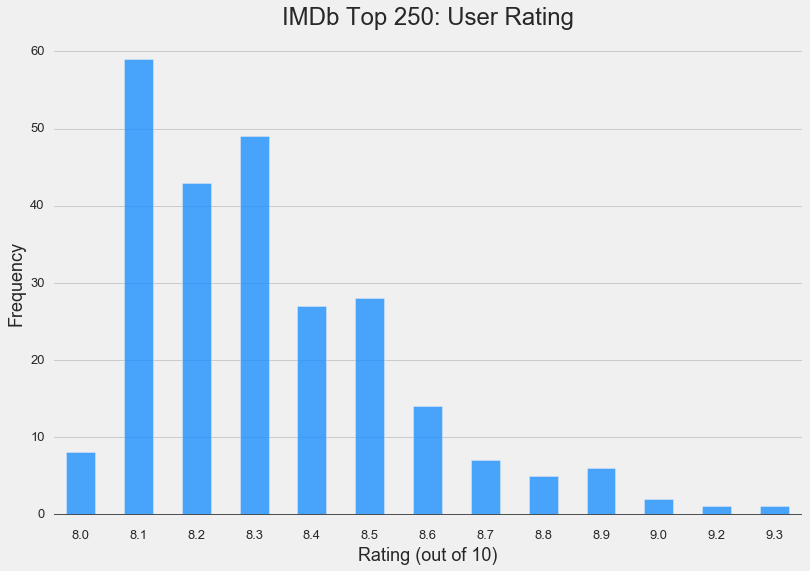

In [17]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

ratings = pd.DataFrame(top['rating'].value_counts())
ratings.sort_index(inplace = True)
ratings['rating'].plot.bar(color = 'dodgerblue', alpha = 0.8)

plt.axhline(0, color='black', alpha = 0.6, linewidth = 1)
plt.title('IMDb Top 250: User Rating', fontsize = 24, y = 1.03)

# y label
plt.yticks(range(0, 85, 10), fontsize = 13)
plt.ylabel('Frequency', fontsize = 18)

# x label
plt.xticks(rotation = 0, fontsize = 13)
plt.xlabel('Rating (out of 10)', fontsize = 18)

#plt.xlim([min(top['rating']), 10])
plt.ylim([-1, 61])

plt.grid(which = 'major', axis = 'x')

plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This looks like a normal distribution cut off near the mean; the 8.0-rated movies are likely underrepresented with respect to overall distribution because they are filling out the bottom of the list.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Is index number random?  Didn't seem like it, above, and it is very clearly not, from this plot of index number vs. user rating: 

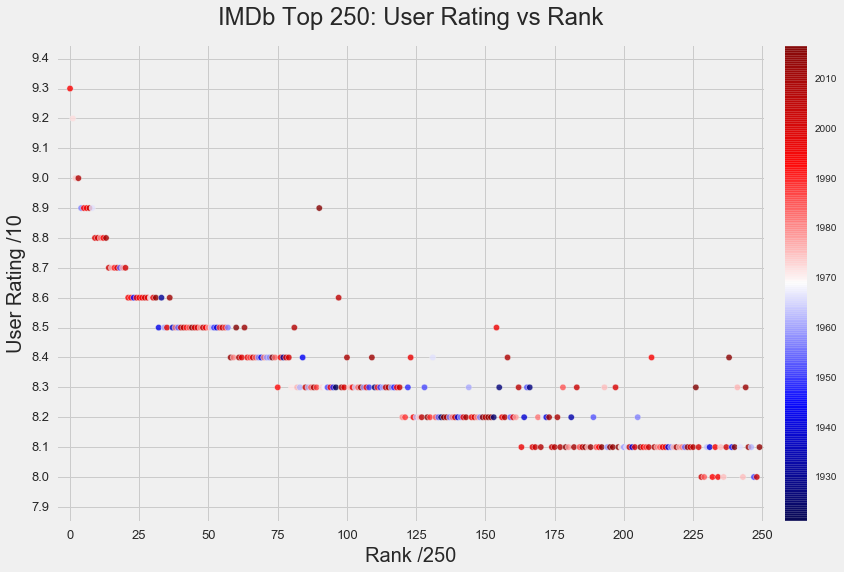

In [18]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

minrating = top['rating'].min()
maxrating = top['rating'].max()

ax = plt.subplot(111)
im = plt.scatter(top.index, top['rating'], \
                c = top['year'], cmap = 'seismic', s = 40, alpha = 0.8)

plt.title('IMDb Top 250: User Rating vs Rank', fontsize = 24, y = 1.03)

# y label
plt.ylabel('User Rating /10', fontsize = 20)
plt.yticks(np.arange(minrating - 0.1, maxrating + 0.2, 0.1), fontsize = 13)
plt.ylim([minrating - 0.15, maxrating + 0.15])

# x label
plt.xlabel('Rank /250', fontsize = 20)
plt.xticks(range(0, 275, 25), fontsize = 13)
plt.xlim([-5, 251])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.25, alpha = 0.8)
plt.colorbar(im, cax=cax)

plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;What's up with those outliers?  Looks the plot should be slightly-overlapping steps moving downward to the right.  We'll consider taking these out of the data set because they are clearly exceptions to the general trend of user rating being negatively correlated with index number.  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let's look at some boxplots:

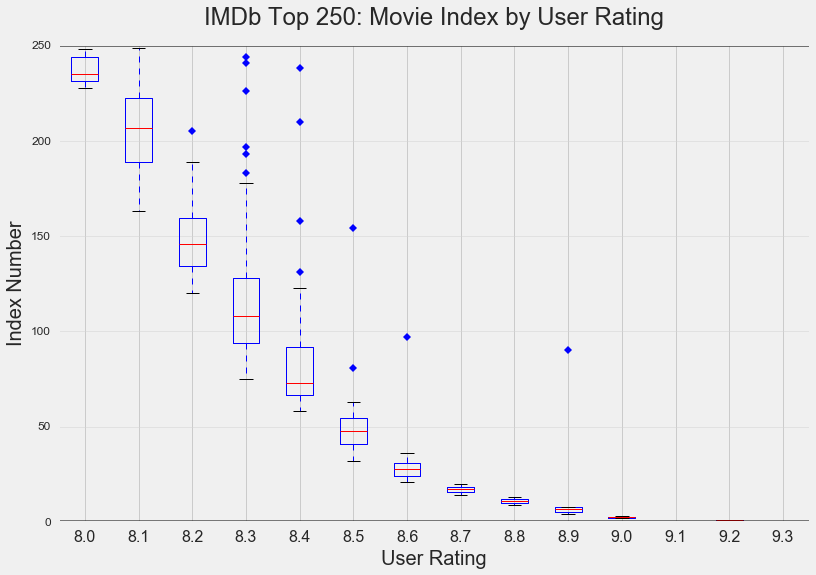

In [19]:
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))

data = []
for i in np.arange(8.0, 9.4, 0.1):
    m = round(i, 2)
    data.append(top[top['rating'] == m].index)

plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('IMDb Top 250: Movie Index by User Rating', y =1.03, fontsize = 24)
ax1.set_xlabel('User Rating', fontsize = 20)
ax1.set_ylabel('Index Number', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = len(np.arange(minrating, maxrating, 0.1))
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(0, 251)
xtickNames = plt.setp(ax1, xticklabels = np.arange(minrating, maxrating, 0.1))
plt.setp(xtickNames, fontsize=16)
ytickNames = plt.setp(ax1, yticklabels=range(0, 300, 50))
plt.setp(ytickNames, fontsize=12)

plt.axhline(0, color='black', alpha = 0.5)
plt.axhline(250, color='black', alpha = 0.5, linewidth = 1)

del data

plt.show()

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Create list of scaled areas for each movie's user rating:

In [20]:
top['rating_area'] = MinMaxScaler([20, 500]).fit_transform(top['rating'].reshape(-1,1))

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Create list of scaled areas for each movie's year of release:

In [21]:
top['year_area'] = MinMaxScaler([20, 500]).fit_transform(top['year'].reshape(-1,1))

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The scatterplot below suggests that the more votes a movie has, the higher its rating will be.  We see that older movies tend to have fewer votes.  Also, the spread in older movies' ratings is smaller and the average rating appears lower. (Jitter assistance from [here](http://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot).)

In [22]:
def rand_jitter(arr):
    displacement = .005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * displacement

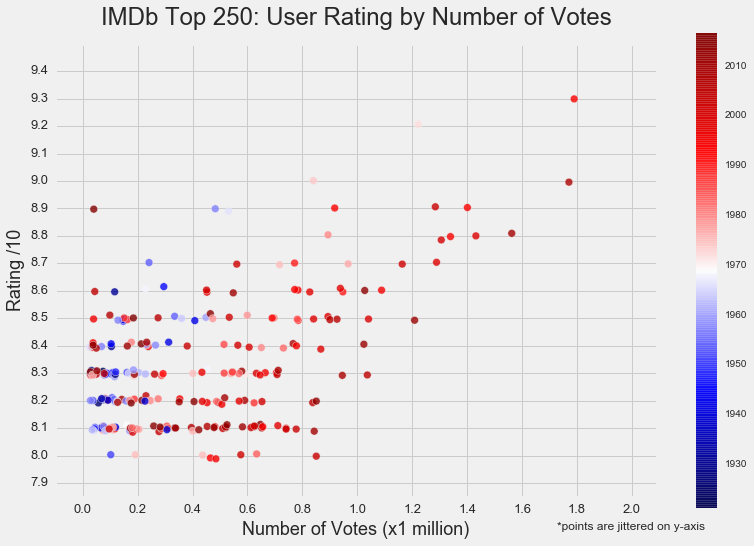

In [23]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

minyear = top['year'].min()
maxyear = top['year'].max()
maxvotes = top['num_votes'].max()

div = 1000000.

plt.scatter(top['num_votes']/div, rand_jitter(top['rating']), \
            c = top['year'], cmap = 'seismic', alpha = 0.8, s = 60)


plt.title('IMDb Top 250: User Rating by Number of Votes', fontsize = 24, y = 1.03)
plt.axhline(0, color='darkblue', alpha = 0.5)

plt.ylabel('Rating /10', fontsize = 18)
plt.yticks(np.arange(minrating - 0.1, maxrating + 0.2, 0.1), fontsize = 13)
plt.ylim([minrating - 0.15, maxrating + 0.2])

plt.xlabel('Number of Votes (x1 million)', fontsize = 18)
plt.xticks(np.arange(-0.2, maxvotes/div + 1.6, 0.2), fontsize = 13)
plt.xlim([-0.1, maxvotes/div + 0.3])

plt.grid(True)

plt.annotate('*points are jittered on y-axis', (1,0), (-100, -25), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)

img = plt.imshow(np.array([[minyear, maxyear]]), cmap="seismic", alpha = 0.8)
img.set_visible(False)
plt.colorbar()

plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let's use OMDb API to get whatever else we can:

In [24]:
# URLs = []
# for tconst in top['tconst']:
#     URLs.append('http://www.omdbapi.com/?i='+tconst+'&plot=full')

In [25]:
# def omdb_info(url):
#     response = urlopen(Request(url))
#     info = pd.read_json(response.read(), typ='series', orient='values')
#     return info

In [26]:
# counter = 1
# omdb_df = pd.DataFrame()
# for url in URLs:
#     lil_df = omdb_info(url)
#     omdb_df = pd.concat([omdb_df, lil_df], axis=1, ignore_index=True )
#     if counter%10 == 0:
#         print counter,
#     counter += 1
    
# omdb_df = omdb_df.T

# omdb_df.to_csv('assets/omdb_df.csv', index = False, encoding = 'utf-8')

In [27]:
omdb_df = pd.read_csv('assets/omdb_df.csv')

omdb_df.head(1)

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,Released,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes
0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Nominated for 7 Oscars. Another 19 wins & 30 n...,USA,Frank Darabont,"Crime, Drama",English,80.0,Chronicles the experiences of a formerly succe...,https://images-na.ssl-images-amazon.com/images...,R,14 Oct 1994,True,142 min,The Shawshank Redemption,movie,"Stephen King (short story ""Rita Hayworth and S...",1994,tt0111161,9.3,"1,786,262"


In [28]:
omdb_df['Response'].value_counts()

True    250
Name: Response, dtype: int64

In [29]:
omdb_df['Type'].value_counts()

movie    250
Name: Type, dtype: int64

In [30]:
omdb_df.drop(['Metascore', 'Poster', 'Response', \
              'Title', 'Type', 'imdbRating', 'imdbVotes'], axis = 1, inplace = True)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Concatenate with previous dataframe:

In [31]:
big_top = pd.merge(top, omdb_df, how='inner', on=None, left_on='tconst', right_on='imdbID',
         left_index=False, right_index=False, sort=True, copy=True, indicator=False)

big_top.to_csv('assets/big_top.csv', index = False)

In [32]:
big_top = pd.read_csv('assets/big_top.csv')

big_top.head(1)

,num_votes,rating,tconst,title,year,rating_area,year_area,Actors,Awards,Country,Director,Genre,Language,Plot,Rated,Released,Runtime,Writer,Year,imdbID
0,73907,8.3,tt0012349,The Kid,1921.0,130.769231,20.0,"Carl Miller, Edna Purviance, Jackie Coogan, Ch...",1 win.,USA,Charles Chaplin,"Comedy, Drama, Family",English,"The opening title reads: ""A comedy with a smil...",NOT RATED,06 Feb 1921,68 min,Charles Chaplin,1921,tt0012349


In [33]:
big_top['Rated'].value_counts()

R            101
PG            36
NOT RATED     32
PG-13         31
APPROVED      20
G             14
UNRATED       10
PASSED         3
Name: Rated, dtype: int64

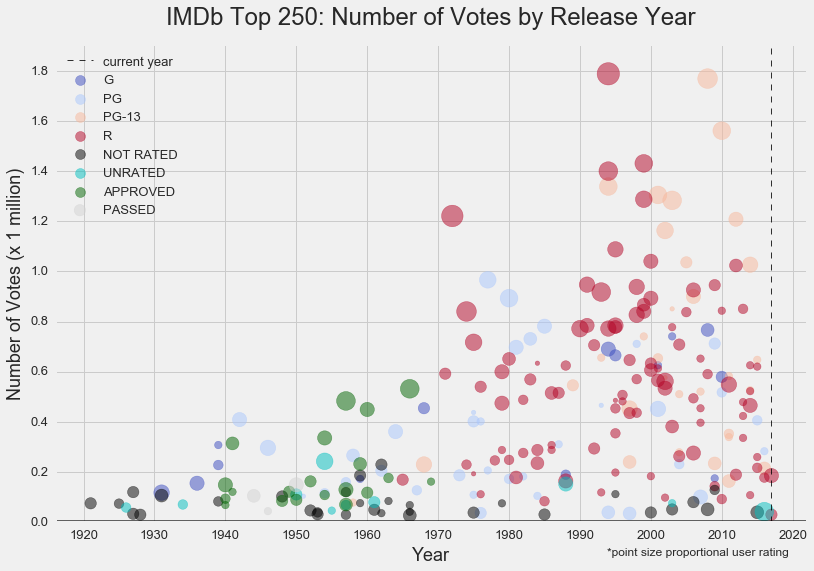

In [34]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

# assign colors to ranked certifications
cert = ['G', 'PG', 'PG-13', 'R']
cert_colors = []
for i in range(0, 256, 256/3):
    cert_colors.append(cm.coolwarm(i))
cert_dict = dict(zip(cert, cert_colors))
del cert, cert_colors

cert_dict2 = {
    'UNRATED' : 'c',
    'NOT RATED' : 'black',
    'APPROVED' : 'darkgreen',
    'PASSED' : 'lightgrey'
}

cert_dict.update(cert_dict2)    
    
plot_order = ['G', 'PG', 'PG-13', 'R', 'NOT RATED', 'UNRATED', 'APPROVED', 'PASSED']

for i in plot_order:
    y = big_top.loc[big_top['Rated'] == i, :]
    plt.scatter(y['year'], y['num_votes']/1000000, color = cert_dict[i], alpha = 0.5, \
                s = y['rating_area'], label = i)

plt.title('IMDb Top 250: Number of Votes by Release Year', fontsize = 24, y = 1.03)

# add x-axis line and a line to show current year
plt.axhline(0, color='black', alpha = 0.6)
plt.axvline(maxyear, color='black', linestyle='dashed', linewidth=0.8, \
            label = 'current year')

# y label
plt.ylabel('Number of Votes (x 1 million)', fontsize = 18)
plt.yticks(np.arange(0, 2.2, 0.2), fontsize = 13)

# x label
plt.xlabel('Year', fontsize = 18)
plt.xticks(np.arange(minyear - minyear%10, maxyear + 5, 10), fontsize = 13)

# set the figure boundaries
plt.xlim([minyear - 5, maxyear + 5])
plt.ylim([0, 1.91])

plt.grid(True)
lgnd = plt.legend(loc='upper left', fontsize = 13)

for lil in range(0, len(plot_order)):
    lgnd.legendHandles[lil]._sizes = [100]
    
plt.annotate('*point size proportional user rating', (1,0), (-200, -25), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)


plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;What are those two pre-1970 PG-13 movies?

In [35]:
big_top[big_top['Rated'] == 'PG-13'][['title', 'year']].sort_values(by = 'year').head(2)

,title,year
45,Touch of Evil,1958.0
69,Once Upon a Time in the West,1968.0


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;What's the red dot outlier in the 1970s up high?  

In [36]:
big_top[(big_top['year'] < 1980) & (big_top['num_votes'] > 1000000)][['title', 'rating', \
                                                            'year', 'num_votes']]

,title,rating,year,num_votes
71,The Godfather,9.2,1972.0,1221863


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The Godfather!  From the 1990s onward, there does seem to be a drastic increase in the number of votes; this probably has to do with the invention of the internet, popularity increase of IMDb, and other factors not inherently related to movie quality.  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;There is no evidence here that average movie quality is itself increasing over time.  Accelerated increase in number of votes begins in the 1970s; this was a turning point in American movies as the MPAA changed its audience viewing codes.  From Wikipedia:  "In 1968, after several years of minimal enforcement, the outdated Production Code was replaced by the [MPAA film rating system](https://en.wikipedia.org/wiki/Motion_Picture_Production_Code)." 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We'll dummify the MPAA rating column while we're here:

In [37]:
big_top = pd.concat([big_top, pd.get_dummies(big_top['Rated'])], axis = 1)

### Runtime

In [38]:
big_top['Runtime'] = big_top['Runtime'].apply(lambda x: int(x.split()[0]))

In [39]:
big_top['runtime_area'] = MinMaxScaler([10, 700]).fit_transform(big_top['Runtime'].astype(float).reshape(-1,1))

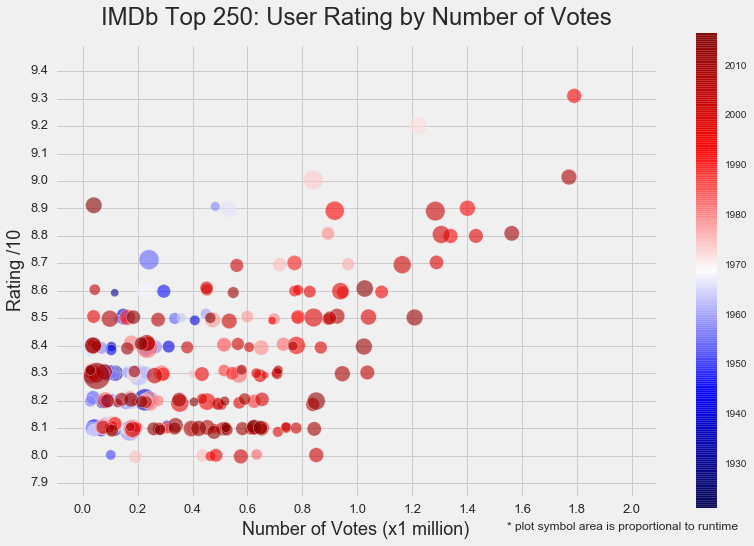

In [40]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

maxvotes = big_top['num_votes'].max()

div = 1000000.

plt.scatter(big_top['num_votes']/div, rand_jitter(big_top['rating']), \
            c = big_top['year'], cmap = 'seismic', alpha = 0.6, s = big_top['runtime_area'])


plt.title('IMDb Top 250: User Rating by Number of Votes', fontsize = 24, y = 1.03)
plt.axhline(0, color='darkblue', alpha = 0.5)

plt.ylabel('Rating /10', fontsize = 18)
plt.yticks(np.arange(minrating - 0.1, maxrating + 0.2, 0.1), fontsize = 13)
plt.ylim([minrating - 0.15, maxrating + 0.2])

plt.xlabel('Number of Votes (x1 million)', fontsize = 18)
plt.xticks(np.arange(-0.2, maxvotes/div + 1.6, 0.2), fontsize = 13)
plt.xlim([-0.1, maxvotes/div + 0.3])

plt.grid(True)

plt.annotate('* plot symbol area is proportional to runtime', (1,0), (-150, -25), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)

img = plt.imshow(np.array([[minyear, maxyear]]), cmap="seismic", alpha = 0.8)
img.set_visible(False)
plt.colorbar()

plt.show()

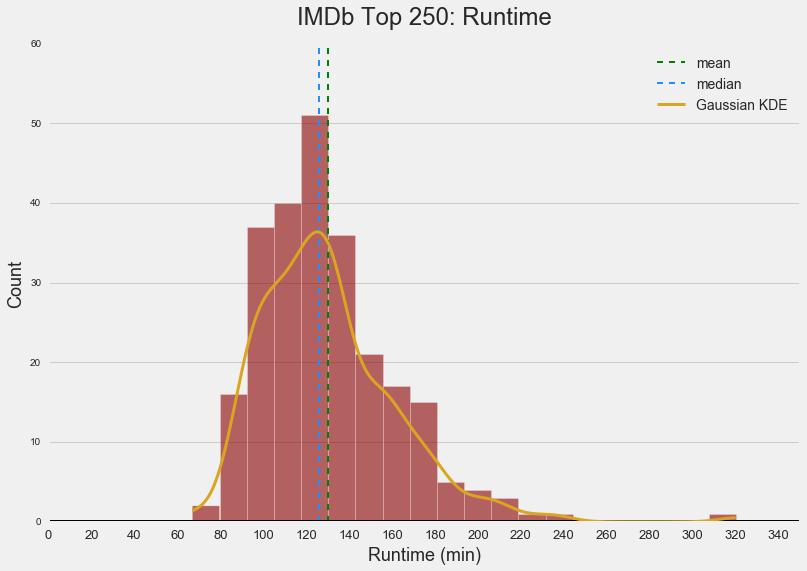

In [41]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(big_top['Runtime'], color = 'darkred', alpha = 0.6, \
                bins = 20)
plt.axvline(big_top['Runtime'].mean(), color='g', linestyle='dashed', linewidth = 2, \
                label = 'mean')
plt.axvline(big_top['Runtime'].median(), color='dodgerblue', linestyle='dashed', \
                linewidth = 2, label = 'median')
plt.axhline(0, color='black')
plt.title('IMDb Top 250: Runtime', fontsize = 24, y = 1.03)

plt.ylabel('Count', fontsize = 18)

plt.xlabel('Runtime (min)', fontsize = 18)
plt.xticks(range(0, 380, 20), fontsize = 13)
plt.xlim([0, big_top['Runtime'].max() + 30])

density = gaussian_kde(big_top.loc[:, 'Runtime'])
xs = np.linspace(big_top['Runtime'].min(), big_top['Runtime'].max(), 1000)
density.covariance_factor = lambda : 0.25
density._compute_covariance()
plt.plot(xs, density(xs)*10000/4, linewidth = 3, label = 'Gaussian KDE', \
         color = 'goldenrod', alpha = 1)

plt.legend(loc='best', fontsize = 14)

plt.grid(which = 'major', axis = 'x')

plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Here are the movies whose runtimes are more than three standard deviations above the mean:

In [42]:
big_top[big_top['Runtime'] > (big_top['Runtime'].mean() + 3.0 * np.std(big_top['Runtime']))]\
[['title', 'year', 'rating','Runtime']].sort_values(by = 'Runtime', ascending = False)

,title,year,rating,Runtime
231,Gangs of Wasseypur,2012.0,8.3,320
10,Gone with the Wind,1939.0,8.2,238
105,Once Upon a Time in America,1984.0,8.4,229


### Month

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Now, let's make a bar chart of month of release.  First, we must fill in missing values:

In [43]:
big_top[big_top['Released'].isnull()][['title', 'year', 'Country']]

,title,year,Country
1,The Gold Rush,1925.0,USA
57,What Ever Happened to Baby Jane?,1962.0,USA
63,Andrei Rublev,1966.0,Soviet Union


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Thanks, internet:

In [44]:
big_top.loc[big_top['title'] == 'The Gold Rush', 'Released'] = '26 Jun 1925'
big_top.loc[big_top['title'] == 'What Ever Happened to Baby Jane?', 'Released'] = '31 Oct 1962'
big_top.loc[big_top['title'] == 'Andrei Rublev', 'Released'] = 'x Dec 1966'

In [45]:
big_top['month'] = [x.split()[1] for x in big_top['Released']]

In [46]:
big_top['month'].value_counts()

Dec    31
Feb    25
Jun    24
Mar    24
Nov    23
Oct    22
Jan    21
Jul    18
Sep    18
Aug    16
May    15
Apr    13
Name: month, dtype: int64

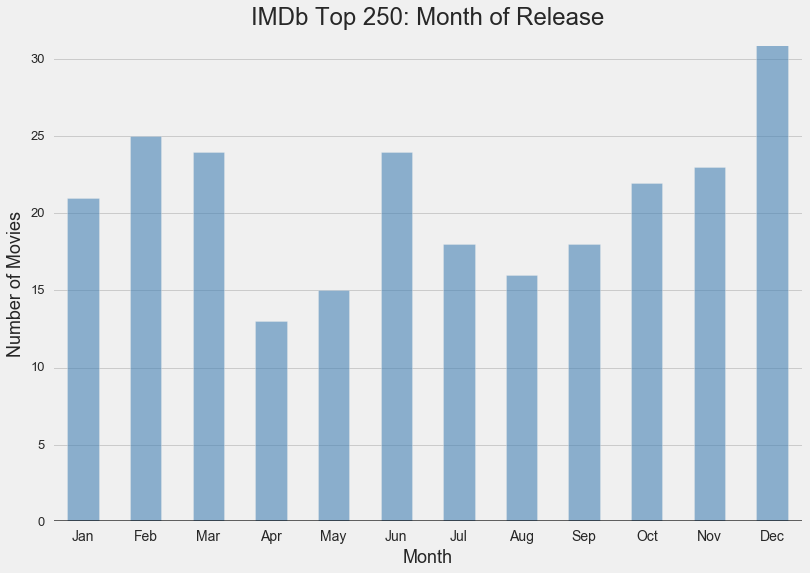

In [47]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

y = pd.DataFrame(big_top['month'].value_counts())
y.columns = ['count']
y['month'] = y.index
y.reset_index(drop = True, inplace = True)

y['order'] = y['month'].apply(lambda x: list(calendar.month_abbr).index(x))
y = y.sort_values(by = 'order')
y = y.drop('month', axis = 1).set_index(y['month'], drop = True)

## PLOT IT

y['count'].plot.bar(color = 'steelblue', alpha = 0.6)

plt.title('IMDb Top 250: Month of Release', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Number of Movies', fontsize = 18)
plt.yticks(range(0, 35, 5), fontsize = 13)
plt.ylim([0, 31])

# x label
plt.xlabel('Month', fontsize = 18)
plt.xticks(rotation=0, fontsize = 14)

plt.axhline(0, color='black', alpha = 0.6)

plt.grid(which = 'major', axis = 'x')

plt.show()

del y

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Nothing counterintuive here; there are summer movies, there are winter/holiday movies, and there are lulls in between.

In [48]:
big_top = pd.concat([big_top, pd.get_dummies(big_top['month'])], axis = 1)

### Country

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let's clean up the country column, consolidating some countries which no long exist (again, thanks, internet!).  We'll end up dummifying countries which appear strictly more than twice in the Top 250 list.

In [49]:
big_top[big_top['Country'] == 'West Germany'][['title', 'year', 'Country']]

,title,year,Country
96,Das Boot,1981.0,West Germany


In [50]:
big_top['Country'] = big_top['Country'].apply(lambda x: x.replace('West Germany', 'Germany'))

In [51]:
big_top[big_top['Country'] == 'Soviet Union'][['title', 'year', 'Country']]

,title,year,Country
63,Andrei Rublev,1966.0,Soviet Union
91,Stalker,1979.0,Soviet Union
110,Come and See,1985.0,Soviet Union


In [52]:
big_top['Country'] = big_top['Country'].apply(lambda x: x.replace('Soviet Union', 'Russia'))

In [53]:
countries = []
for i in range(len(big_top)):
    lil_countries = big_top.loc[i, 'Country'].split(', ')
    for j in lil_countries:
        countries.append(j)
        
country_df = pd.DataFrame(pd.DataFrame(countries)[0].value_counts())

country_df = country_df[country_df[0] > 2]

country_df.T

,USA,UK,France,Germany,Italy,India,Japan,Spain,Canada,Sweden,Hong Kong,Australia,Ireland,New Zealand,Russia
0,180,42,20,17,13,13,12,5,5,4,4,3,3,3,3


In [54]:
for i in country_df.index:
    dummy = []
    for j in range(len(big_top)):
        if i in big_top.loc[j, 'Country']:
            dummy.append(1)
        else:
            dummy.append(0)
    big_top[i] = dummy

### Actors

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We'll find all actors scraped and dummify those appearing more than twice.

In [55]:
actors = []
for i in range(len(big_top)):
    lil_actors = big_top.loc[i, 'Actors'].split(', ')
    for j in lil_actors:
        actors.append(j)
        
actor_df = pd.DataFrame(pd.DataFrame(actors)[0].value_counts())

actor_df = actor_df[actor_df[0] > 2]

actor_df.T

,Harrison Ford,Robert De Niro,Leonardo DiCaprio,Tom Hanks,Clint Eastwood,Aamir Khan,Charles Chaplin,Mark Hamill,Joe Pesci,Christian Bale,...,William Holden,Robert Duvall,Ralph Fiennes,Humphrey Bogart,Ben Kingsley,Matt Damon,Bruce Willis,Gunnar Björnstrand,Brad Pitt,Toshirô Mifune
0,7,7,6,6,5,5,4,4,4,4,...,3,3,3,3,3,3,3,3,3,3


In [56]:
for i in actor_df.index:
    dummy = []
    for j in range(len(big_top)):
        if i in big_top.loc[j, 'Actors']:
            dummy.append(1)
        else:
            dummy.append(0)
    big_top[i] = dummy

### Directors

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;On to directors!  (Note: only first director scraped, all others dropped.)  We'll dummify those appearing strictly more than twice.

In [57]:
directors = []
for i in range(len(big_top)):
    lil_directors = big_top.loc[i, 'Director'].split(', ')
    for j in lil_directors:
        directors.append(j)
        
director_df = pd.DataFrame(pd.DataFrame(directors)[0].value_counts())

director_df = director_df[director_df[0] > 2]

director_df.T

,Steven Spielberg,Alfred Hitchcock,Stanley Kubrick,Christopher Nolan,Martin Scorsese,Billy Wilder,Quentin Tarantino,Charles Chaplin,Hayao Miyazaki,Akira Kurosawa,...,Ridley Scott,David Fincher,Ingmar Bergman,Francis Ford Coppola,Joel Coen,Frank Capra,Sidney Lumet,Pete Docter,Peter Jackson,Ethan Coen
0,7,7,7,7,7,5,5,5,5,5,...,3,3,3,3,3,3,3,3,3,3


In [58]:
for i in director_df.index:
    dummy = []
    for j in range(len(big_top)):
        if i in big_top.loc[j, 'Director']:
            dummy.append(1)
        else:
            dummy.append(0)
    big_top[i] = dummy

### Genre

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Next, we'll find all genres and dummify those appearing strictly more than twice.

In [59]:
genres = []
for i in range(len(big_top)):
    lil_genres = big_top.loc[i, 'Genre'].split(', ')
    for j in lil_genres:
        genres.append(j)
        
genre_df = pd.DataFrame(pd.DataFrame(genres)[0].value_counts())

genre_df = genre_df[genre_df[0] > 2]

genre_df.T

,Drama,Crime,Adventure,Comedy,Thriller,Mystery,Action,Biography,Fantasy,Sci-Fi,Romance,War,History,Animation,Family,Horror,Film-Noir,Western,Sport,Music
0,178,58,56,44,41,34,33,27,22,22,21,20,18,17,13,7,7,6,4,3


In [60]:
for i in genre_df.index:
    dummy = []
    for j in range(len(big_top)):
        if i in big_top.loc[j, 'Genre']:
            dummy.append(1)
        else:
            dummy.append(0)
    big_top[i] = dummy

### Language

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Same here; find all languages, dummify those appearing strictly more than twice.

In [61]:
big_top[big_top['Language'].isnull()][['title', 'year', 'Country']]

,title,year,Country
4,Sunrise,1927.0,USA


In [62]:
big_top.loc[big_top['title'] == 'Sunrise', 'Language'] = 'English'

In [63]:
languages = []
for i in range(len(big_top)):
    lil_languages = big_top.loc[i, 'Language'].split(', ')
    for j in lil_languages:
        languages.append(j)
        
language_df = pd.DataFrame(pd.DataFrame(languages)[0].value_counts())

language_df = language_df[language_df[0] > 2]

language_df.T

,English,French,German,Spanish,Italian,Japanese,Russian,Hindi,Latin,Arabic,Vietnamese,Cantonese,Hebrew,Turkish,Hungarian,Swedish,Sindarin
0,206,40,32,29,22,18,15,11,10,8,4,4,3,3,3,3,3


In [64]:
for i in language_df.index:
    dummy = []
    for j in range(len(big_top)):
        if i in big_top.loc[j, 'Language']:
            dummy.append(1)
        else:
            dummy.append(0)
    big_top[i] = dummy

In [65]:
len(big_top.columns)

152

### Scrape several more features:

In [66]:
# url = 'http://www.imdb.com/title/'

# lil_bigtop = pd.DataFrame(columns = ['budget', 'studio', 'sound', 'aspect', 'color'])

# budget = []
# studio = []
# sound = []
# aspect_ratio = []
# color = []

# big_count = 0

# for tconst in big_top['tconst']:
#     pre_soup = requests.get(url + tconst)
#     soup = BeautifulSoup(pre_soup.content, 'lxml')
    
#     ## budget
#     budgets = []
#     for i in soup.findAll('div', class_ = "txt-block"):
#         count = 0
#         for j in i.findAll('h4'):
#             if 'Budget' in j.text:
#                 budgets.append(i.text)
#     budget.append(budgets)
                
#     ## studio
#     studio_list = []
#     for i in soup.findAll('a', href = re.compile('/company/')):
#         studio_list.append(i.text)
#     studio.append(studio_list)
    
#     ## sound mix
#     sound_mixes = []
#     for i in soup.findAll('a', href = re.compile('/search/title\?sound_mixes')):
#         sound_mixes.append(i.text)
#     sound.append(sound_mixes)
    
#     ## aspect ratio
#     aspects = []
#     for i in soup.findAll('div', class_ = "txt-block"):
#         for j in i.findAll('h4'):
#             if 'Aspect' in j.text:
#                 aspects.append(i.text)
#     aspect_ratio.append(aspects)
                
#     ## color
#     colors = []
#     for i in soup.findAll('a', href = re.compile('/search/title\?colors')):
#         colors.append(i.text)
#     color.append(colors)
    
#     big_count += 1
#     if big_count%10 == 0:
#         print big_count,

# lil_bigtop['aspect_ratio'] = aspect_ratio
# lil_bigtop['color'] = color
# lil_bigtop['sound'] = sound
# lil_bigtop['studio'] = studio
# lil_bigtop['budget'] = budget

# del aspect, color, sound, studio, budget

# lil_bigtop.to_csv('assets/final_big_top.csv', index = False)

In [67]:
lil_bigtop = pd.read_csv('assets/final_big_top.csv')

big_top = pd.concat([big_top, lil_bigtop], axis = 1)

big_top.head(1)

,num_votes,rating,tconst,title,year,rating_area,year_area,Actors,Awards,Country,...,Turkish,Hungarian,Swedish,Sindarin,budget,studio,sound,aspect,color,aspect_ratio
0,73907,8.3,tt0012349,The Kid,1921.0,130.769231,20.0,"Carl Miller, Edna Purviance, Jackie Coogan, Ch...",1 win.,USA,...,0,0,0,0,"[u'\nBudget: $250,000 \n\n ...",[u'Charles Chaplin Productions'],"[u'Mono', u'Silent']",NaN,[u' Black and White'],[u'\nAspect Ratio: 1.33 : 1\n ']


In [68]:
big_top['aspect_ratio'].head()

0    [u'\nAspect Ratio: 1.33 : 1\n    ']
1    [u'\nAspect Ratio: 1.33 : 1\n    ']
2    [u'\nAspect Ratio: 1.33 : 1\n    ']
3    [u'\nAspect Ratio: 1.33 : 1\n    ']
4    [u'\nAspect Ratio: 1.33 : 1\n    ']
Name: aspect_ratio, dtype: object

### Aspect Ratio

In [69]:
for i in range(len(big_top)):
    try:
        big_top.loc[i, 'aspect_ratio'] = float(big_top.loc[i, 'aspect_ratio'].split(' : ')[0].split(': ')[1])
    except:
        big_top.loc[i, 'aspect_ratio'] = np.nan

In [70]:
big_top[big_top['aspect_ratio'].isnull()][['title', 'year', 'Country', 'aspect']]

,title,year,Country,aspect
129,Andaz Apna Apna,1994.0,India,NaN
144,The Bandit,1996.0,"Turkey, France, Bulgaria",NaN
171,Hera Pheri,2000.0,India,NaN
202,My Father and My Son,2005.0,Turkey,NaN
219,A Wednesday,2008.0,India,NaN
247,Drishyam,2015.0,India,NaN
249,Dangal,2016.0,India,NaN


Mostly found on Amazon.com:

In [71]:
big_top.loc[big_top['title'] == 'Andaz Apna Apna', 'aspect'] = 1.33
big_top.loc[big_top['title'] == 'The Bandit', 'aspect'] = 1.78
big_top.loc[big_top['title'] == 'Hera Pheri', 'aspect'] = 2.35
big_top.loc[big_top['title'] == 'My Father and My Son', 'aspect'] = 1.33
big_top.loc[big_top['title'] == 'A Wednesday', 'aspect'] = 1.85
big_top.loc[big_top['title'] == 'Drishyam', 'aspect'] = 2.35
big_top.loc[big_top['title'] == 'Dangal', 'aspect'] = 2.35

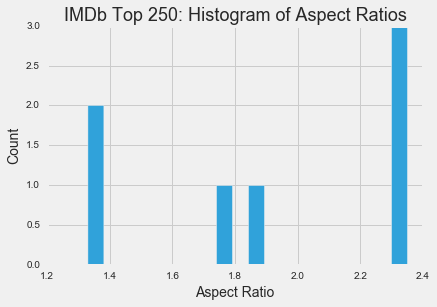

In [72]:
plt.style.use('fivethirtyeight')
plt.title('IMDb Top 250: Histogram of Aspect Ratios', fontsize = 18)
plt.xlabel('Aspect Ratio', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
big_top['aspect'].hist(bins = 20)

plt.show()

### Studio

In [73]:
studio_list = []

for i in range(len(big_top)):
    for j in ast.literal_eval(big_top.loc[i, 'studio']):
        studio_list.append(j)
        
studio_df = pd.DataFrame(pd.DataFrame(studio_list)[0].value_counts())

studio_df = studio_df[studio_df[0] > 2]

studio_df.T

,Warner Bros.,Universal Pictures,Paramount Pictures,Walt Disney Pictures,Columbia Pictures Corporation,Metro-Goldwyn-Mayer (MGM),Twentieth Century Fox Film Corporation,Pixar Animation Studios,DreamWorks,Lucasfilm,...,Syncopy,Nibariki,Mosfilm,Constantin Film Produktion,WingNut Films,Toho Company,"Ladd Company, The",Svensk Filmindustri (SF),Studio Ghibli,Paramount Vantage
0,28,15,14,11,9,8,7,7,6,6,...,3,3,3,3,3,3,3,3,3,3


In [74]:
for i in studio_df.index:
    dummy = []
    for j in range(len(big_top)):
        if i in big_top.loc[j, 'studio']:
            dummy.append(1)
        else:
            dummy.append(0)
    big_top[i] = dummy

### Budget -- not using for now

In [75]:
for i in range(len(big_top)):
    try:
        big_top.loc[i, 'budget'] = ast.literal_eval(big_top.loc[i, 'budget'])[0].split('        ')[1]
    except:
        big_top.loc[i, 'budget'] = np.nan

In [76]:
big_top['budget'].isnull().sum()

23

In [77]:
big_top[big_top['budget'].isnull()][['title', 'year', 'budget', 'Country']]

,title,year,budget,Country
4,Sunrise,1927.0,NaN,USA
5,The Passion of Joan of Arc,1928.0,NaN,France
7,M,1931.0,NaN,Germany
24,The Third Man,1949.0,NaN,UK
29,Ikiru,1952.0,NaN,Japan
31,The Wages of Fear,1953.0,NaN,"France, Italy"
32,Tokyo Story,1953.0,NaN,Japan
33,Diabolique,1955.0,NaN,France
40,The Nights of Cabiria,1957.0,NaN,"Italy, France"
43,Wild Strawberries,1957.0,NaN,Sweden


In [78]:
# big_top.loc[big_top['title'] == 'Sunrise', 'budget'] = '$200,000'
# big_top.loc[big_top['title'] == 'The Passion of Joan of Arc', 'budget'] = 'FRF 7,000,000'
# big_top.loc[big_top['title'] == 'M', 'budget'] = np.nan
# big_top.loc[big_top['title'] == 'The Third Man', 'budget'] = np.nan
# big_top.loc[big_top['title'] == 'Ikiru', 'budget'] = np.nan
# big_top.loc[big_top['title'] == 'The Wages of Fear', 'budget'] = 
# big_top.loc[big_top['title'] == 'Tokyo Story', 'budget'] = 
# big_top.loc[big_top['title'] == 'Diabolique', 'budget'] = 
# big_top.loc[big_top['title'] == 'The Nights of Cabiria', 'budget'] = 
# big_top.loc[big_top['title'] == 'Wild Strawberries', 'budget'] = 
# big_top.loc[big_top['title'] == 'The 400 Blows', 'budget'] = 
# big_top.loc[big_top['title'] == 'Yojimbo', 'budget'] = 
# big_top.loc[big_top['title'] == '8½', 'budget'] = 
# big_top.loc[big_top['title'] == '', 'budget'] = 


In [79]:
# for i in range(len(big_top)):
#     try:
#         if '$' in big_top.loc[i, 'budget']:
#             if 'USA' in big_top.loc[i, 'Country']:
#                 pass
#             else:
#                 print big_top.loc[i, 'Country']
#         else:
#             pass
#     except: 
#         pass

### Sound

In [80]:
sound_list = []

for i in range(len(big_top)):
    try:
        sound_list.append(ast.literal_eval(big_top.loc[i, 'sound'])[0])
    except:
        sound_list.append(None)
        
sound_df = pd.DataFrame(pd.DataFrame(sound_list)[0].value_counts())

sound_df = sound_df[sound_df[0] > 2]

sound_df.T

,Mono,Dolby Digital,DTS,70 mm 6-Track,SDDS,Dolby,Dolby SR,DTS-ES,Dolby Stereo,4-Track Stereo,Silent
0,78,56,30,17,13,11,9,6,4,4,3


In [81]:
for i in sound_df.index:
    dummy = []
    for j in range(len(big_top)):
        if i in big_top.loc[j, 'sound']:
            dummy.append(1)
        else:
            dummy.append(0)
    big_top[i] = dummy

### Color

In [82]:
big_top['color'].value_counts()

[u'Color']                                                                   170
[u' Black and White']                                                         52
[u' Black and White', u'Color']                                               12
[u'Color', u' Black and White']                                                8
[u'Color', u'Color']                                                           5
[u' Black and White', u' Black and White', u' Black and White', u'Color']      1
[u'Color', u' Black and White', u'Color']                                      1
[]                                                                             1
Name: color, dtype: int64

In [83]:
big_top[big_top['color'] == '[]'][['title', 'year', 'Country']]

,title,year,Country
144,The Bandit,1996.0,"Turkey, France, Bulgaria"


In [84]:
big_top.loc[big_top['title'] == 'The Bandit', 'color'] = '[u\'Color\']'

In [85]:
for whichlet in ['Black and White', 'Color']:
    dummy = []
    for i in range(len(big_top)):
        which = ast.literal_eval(big_top.loc[i, 'color'])[0].lstrip()
        if which in whichlet:
            dummy.append(1)
        else:
            dummy.append(0)
    big_top[whichlet] = dummy        

In [86]:
len(big_top.columns)

201

## Cluster Analysis

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let's do cluster analyses with KMeans and DBSCAN to see if we can find some interesting clustering patters in the IMDb Top 250.  We'll remove number of votes and IMDb User Rating from the feature set, since those are not inherent to the movies themselves.  Other columns have been dummified already and we will remove the originals:

In [87]:
feats = big_top.drop(['num_votes', 'rating', 'tconst', 'rating_area', 'year_area', 'Actors', 'Awards', 'Country', \
                  'Director', 'Genre', 'Language', 'Plot', 'Rated', 'Released', 'Writer', 'Year', 'imdbID', \
                  'runtime_area', 'month', 'color', 'studio', 'budget', 'sound'], axis = 1)

try:
    feats.drop('aspect', axis = 1, inplace = True)
except:
    pass

try:
    feats.drop('aspect_ratio', axis = 1, inplace = True)
except:
    pass

feats.set_index('title', inplace = True)

X = pd.DataFrame(StandardScaler().fit_transform(feats), columns = feats.columns)

In [88]:
X.head(2)

,year,Runtime,APPROVED,G,NOT RATED,PASSED,PG,PG-13,R,UNRATED,...,70 mm 6-Track,SDDS,Dolby,Dolby SR,DTS-ES,Dolby Stereo,4-Track Stereo,Silent,Black and White,Color
0,-2.622026,-1.931286,-0.294884,-0.243561,2.610077,-0.110208,-0.410152,-0.376235,-0.823318,-0.204124,...,-0.302825,-0.531085,-1.288245,-0.224544,-0.193247,-0.193247,-0.156813,5.891883,1.687055,-1.687055
1,-2.456692,-1.092731,-0.294884,-0.243561,2.610077,-0.110208,-0.410152,-0.376235,-0.823318,-0.204124,...,-0.302825,-0.531085,-1.288245,-0.224544,-0.193247,-0.193247,-0.156813,5.891883,1.687055,-1.687055


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Out of curiosity, let's find the distribution of Euclidean distances between every pair of points:  

In [89]:
distances = []
for i in range(len(X)):
    for j in range(i+1, len(X)):
        a = np.array(X.loc[i, :])
        b = np.array(X.loc[j, :])
        distances.append(distance.euclidean(a, b))

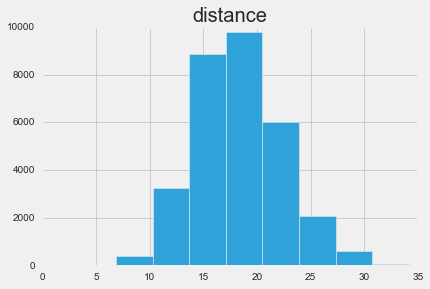

In [90]:
pd.DataFrame(distances, columns = ['distance']).hist()
plt.show()

## KMeans

In [91]:
start = datetime.datetime.now()
print start

ksilhouette = []
for i in range(2, 250):
    kmeans = KMeans(n_clusters=i, random_state = 42)
    kmeans.fit(X)
    ksilhouette.append((i, silhouette_score(X, kmeans.labels_, metric='euclidean')))
    
print (datetime.datetime.now() - start)         

2017-03-28 21:40:13.084755
0:03:04.120684


In [92]:
ksilhouette = pd.DataFrame(ksilhouette, columns = ['clusters', 'silhouette'], index = range(0, len(ksilhouette)))

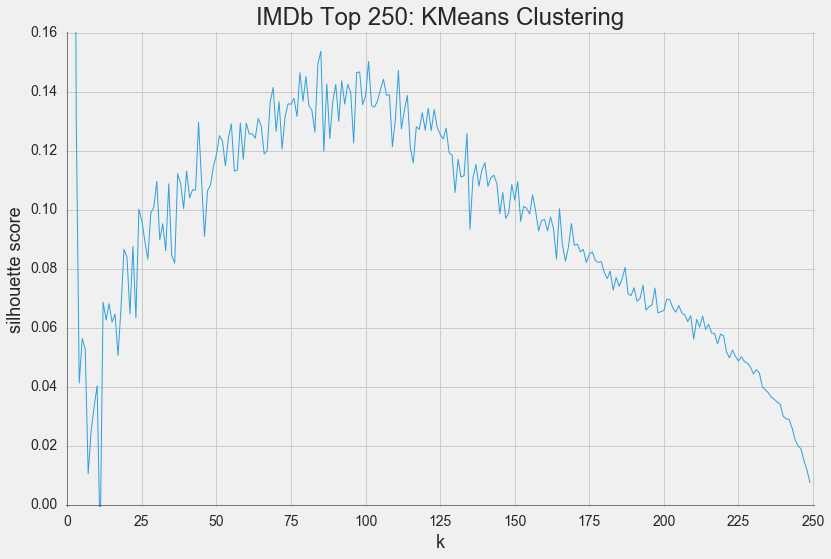

In [93]:
plt.figure(figsize = (12,8))
plt.style.use('fivethirtyeight')

plt.plot(range(2,250), ksilhouette['silhouette'], linewidth = 1)

plt.title('IMDb Top 250: KMeans Clustering', fontsize = 24)

plt.xlabel('k', fontsize = 18)
plt.xlim([-1, 251])
plt.xticks(range(0, 275, 25), fontsize = 14)

plt.ylabel('silhouette score', fontsize = 18)
plt.ylim([-0.001, 0.161])
plt.yticks(np.arange(0, 0.18, 0.02), fontsize = 14)

plt.axhline(0, lw = 1, color = 'k', alpha = 0.4)
plt.axvline(0, lw = 1, color = 'k', alpha = 0.4)

plt.show()

In [94]:
# freq = 5

# decomposition = sm.tsa.seasonal_decompose(np.array(ksilhouette['silhouette']), freq = freq)  
# fig = plt.figure()  
# fig = decomposition.plot()  
# fig.set_size_inches(15, 8)
# plt.show()

In [95]:
# plt.style.use('fivethirtyeight')
# plt.figure(figsize = (12,8))

# lil_df = pd.DataFrame(zip(ksilhouette['clusters'], decomposition.trend), columns = ['clusters', 'trend'])
# lil_df = lil_df[np.isfinite(lil_df['trend'])]

# plt.plot(lil_df['clusters'], lil_df['trend'], alpha = 0.6, lw = 2, color = 'dodgerblue', label = 'stops, trend')

# plt.title('IMDb Top 250: KMeans Clustering -- Trend', fontsize = 24)

# plt.xlabel('k', fontsize = 18)
# plt.xlim([-1, 251])
# plt.xticks(range(0, 275, 25), fontsize = 14)

# plt.ylabel('silhouette score', fontsize = 18)
# plt.ylim([-0.001, 0.161])
# plt.yticks(np.arange(0, 0.18, 0.02), fontsize = 14)

# plt.axhline(0, lw = 1, color = 'k', alpha = 0.4)
# plt.axvline(0, lw = 1, color = 'k', alpha = 0.4)

# plt.show()

Let's check out what clusters look like using KMeans:

In [118]:
n = 10

kmeans = KMeans(n_clusters = n, random_state = 42)
kmeans.fit(X)
silhouette_score(X, kmeans.labels_, metric='euclidean')

0.040393282439605403

In [119]:
feats['silhouette'] = kmeans.labels_

In [120]:
count = 1
for i in range(n):
    mask = (kmeans.labels_ == i)
    print 'CLUSTER #%s' %count
    print list(feats[mask].index)
    print '\n'   
    count += 1

CLUSTER #1
['Sholay', 'Andaz Apna Apna', 'Hera Pheri', 'Munna Bhai M.B.B.S.', 'Rang De Basanti', 'Like Stars on Earth', '3 Idiots', 'A Wednesday', 'Gangs of Wasseypur', 'Drishyam', 'Dangal']


CLUSTER #2
['Star Wars: Episode IV - A New Hope', 'Star Wars: Episode V - The Empire Strikes Back', 'Raiders of the Lost Ark', 'Star Wars: Episode VI - Return of the Jedi', 'Nausica\xc3\xa4 of the Valley of the Wind', 'Back to the Future', 'My Neighbor Totoro', 'Indiana Jones and the Last Crusade', 'Jurassic Park', 'The Lion King', 'Toy Story', 'Princess Mononoke', 'Monsters, Inc.', 'Spirited Away', 'Finding Nemo', 'Pirates of the Caribbean: The Curse of the Black Pearl', "Howl's Moving Castle", 'Batman Begins', 'Toy Story 3', 'The Dark Knight', 'The Prestige', 'Interstellar', 'How to Train Your Dragon', 'WALL\xc2\xb7E', 'Up', 'Harry Potter and the Deathly Hallows: Part 2', 'The Dark Knight Rises', 'Inception', 'Mad Max: Fury Road', 'Inside Out', 'Star Wars: Episode VII - The Force Awakens', 'Zoo

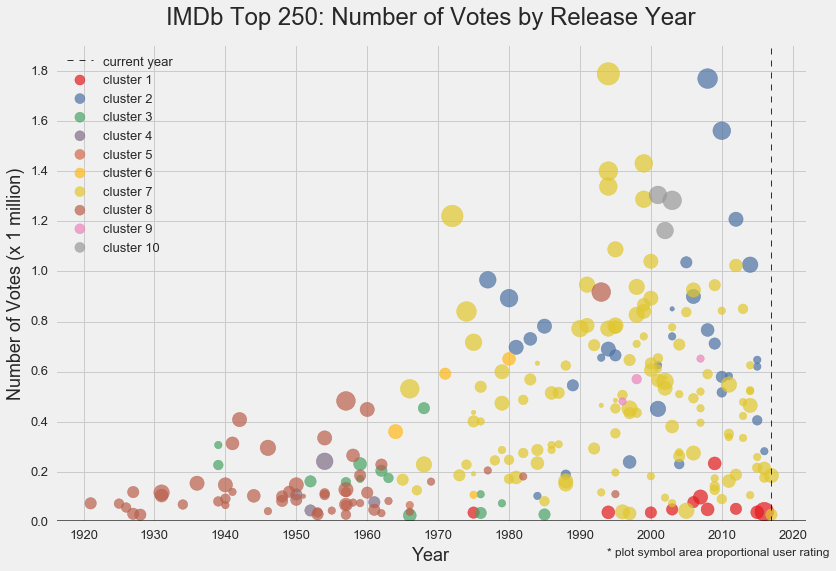

In [121]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

big_top['labels'] = pd.DataFrame(MinMaxScaler().fit_transform(kmeans.labels_.reshape(-1,1)))[0].apply(lambda x: cm.Set1(x))


for lil_label in list(set(kmeans.labels_)):
    y = big_top[kmeans.labels_ == lil_label]
    plt.scatter(y['year'], y['num_votes']/1000000, color = y['labels'], alpha = 0.7, \
                    s = y['rating_area'], label = 'cluster %s' %(int(lil_label) +1))

plt.title('IMDb Top 250: Number of Votes by Release Year', fontsize = 24, y = 1.03)

# add x-axis line and a line to show current year
plt.axhline(0, color='black', alpha = 0.6)
plt.axvline(maxyear, color='black', linestyle='dashed', linewidth=0.8, \
            label = 'current year')

# y label
plt.ylabel('Number of Votes (x 1 million)', fontsize = 18)
plt.yticks(np.arange(0, 2.2, 0.2), fontsize = 13)

# x label
plt.xlabel('Year', fontsize = 18)
plt.xticks(np.arange(minyear - minyear%10, maxyear + 5, 10), fontsize = 13)

# set the figure boundaries
plt.xlim([minyear - 5, maxyear + 5])
plt.ylim([0, 1.91])

plt.grid(True)
lgnd = plt.legend(loc='upper left', fontsize = 13)

for lil in range(0, len(set(kmeans.labels_)) + 1):
    lgnd.legendHandles[lil]._sizes = [100]
    
plt.annotate('* plot symbol area proportional user rating', (1,0), (-200, -25), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)


plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Lot to digest, here.

### DBSCAN

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let's run a nested loop over ranges of epsilon and minimum sample values, calculating the number of clusters and silhouette score as we go:

In [ ]:
start = datetime.datetime.now()
print start 

counts = []

for epsilon in np.arange(1, 25, 0.1):
    for min_pts in range(2, 10):
        db = DBSCAN(eps=epsilon, min_samples=min_pts).fit(X)
        labels = db.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        try:
            silhouette = silhouette_score(X, labels)
        except:
            silhouette = np.nan
                
        counts.append((epsilon, min_pts, n_clusters_, silhouette))
        
        
df = pd.DataFrame(counts, columns = ['epsilon', 'min_samples', 'clusters', 'silhouette'])

df.dropna(inplace = True)

df = df[(df['clusters'] > 1) & (df['silhouette'] > 0)]

df['min_samps_size'] = MinMaxScaler([100,500]).fit_transform(df['min_samples'].astype(float).reshape(-1,1))
df['silhouette_size'] = MinMaxScaler([100,500]).fit_transform(df['silhouette'].astype(float).reshape(-1,1))

end = datetime.datetime.now()

print (end - start)

2017-03-28 22:05:02.809097


In [ ]:
df.head(2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;First, we'll plot epsilon by silhouette score, with warmer color indicating larger number of clusters, and larger plot symbol indicating larger number of minimum samples:

In [ ]:
plt.figure(figsize = (12,8))
plt.style.use('fivethirtyeight')

ax = plt.subplot(111)

im = plt.scatter(df['silhouette'], df['epsilon'], \
            c = df['clusters'], cmap = 'coolwarm', s = df['min_samps_size'], alpha = 0.8)

plt.title('DBSCAN: Epsilon vs Silhouette Score', y = 1.03, fontsize = 20)

plt.xlabel('Silhouette Score', fontsize = 18)
# plt.xticks(np.arange(-0.3, 0.5, 0.1), fontsize = 14)
# plt.xlim([-0.26, 0.051])
plt.ylabel('Epsilon', fontsize = 18)
# plt.yticks(range(2, 9, 1), fontsize = 14)
# plt.ylim([2.4, 5.1])

plt.axvline(0, ls = '--', lw = 1, color = 'k')

plt.annotate('* plot symbol size proportional to min_samples', (1,0), (-200, -25), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.25, alpha = 0.8)
plt.colorbar(im, cax=cax)
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Next, let's plot epsilon by minimum samples, with warmer color indicating larger number of clusters and larger plot symbol size indicating higher silhouette score:

In [ ]:
plt.figure(figsize = (12,8))
plt.style.use('fivethirtyeight')

ax = plt.subplot(111)

im = plt.scatter(df['min_samples'], df['epsilon'], \
            c = df['clusters'], cmap = 'coolwarm', s = df['silhouette_size'], alpha = 0.8)

plt.title('DBSCAN: Epsilon vs Minimum Samples per Cluster', y = 1.03, fontsize = 20)

plt.xlabel('Minimum Samples', fontsize = 18)
plt.xticks(range(1, 6), fontsize = 14)
# plt.xlim([-0.26, 0.051])
plt.ylabel('Epsilon', fontsize = 18)
plt.yticks(fontsize = 14)
# plt.ylim([2.4, 5.1])

plt.annotate('* plot symbol size proportional to silhouette score', (1,0), (-200, -25), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.25, alpha = 0.8)
plt.colorbar(im, cax=cax)
plt.show()

We'll choose the hyperparameters below to label our clusters; this will show in the coloring of the 3D scatterplot:

In [ ]:
db = DBSCAN(eps=11, min_samples=2).fit(X)
labels = db.labels_

### PCA

In [ ]:
pca = PCA().fit(X)

In [ ]:
pca_df = pd.DataFrame(zip(pca.components_, pca.explained_variance_), columns = ['PC basis vector', 'var_exp'])

pca_df.head()

In [ ]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

pca_df['var_exp'].plot.bar(color = 'slateblue', alpha = 0.6)

plt.title('IMDb Top 250 PCA: Variance Explained', fontsize = 24)

plt.ylabel('Variance Explained', fontsize = 18)
#plt.yticks(range(0, 9), fontsize = 13)
#plt.ylim([0, 9])

plt.xlabel('Principal Component #', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks([])

plt.grid(which = 'major', axis = 'x')

plt.show()

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,8))

cum_var_exp = np.cumsum(pca.explained_variance_ratio_)*100

plt.plot(range(0, len(X.columns)), cum_var_exp, linewidth = 3, color = 'navy', alpha = 0.6)
plt.axhline(y=0, linewidth=2, color='grey', ls='solid')
plt.axhline(y=100, linewidth=1, color='k', ls='dashed')
plt.xlim([-1,len(X.columns)])
plt.xticks(fontsize = 13)
plt.ylim([-5,105])
plt.yticks(range(0, 120, 20), fontsize = 13)
plt.ylabel('Cumulative Variance Explained', fontsize=16)
plt.xlabel('Principle Component #', fontsize=16)  
plt.title('IMDb Top 250 PCA: Cumulative Variance Explained', fontsize=24, y = 1.03)
plt.show()

In [ ]:
X_pca = pd.DataFrame(np.dot(pca.components_[0:3], X.T)).T
X_pca.columns = ['PC0', 'PC1', 'PC2']

X_pca['labels'] = labels
X_pca.head(2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let's check out a 3D plot of our clusters on the first three principal components!  Hovering displays movie title.

In [ ]:
x, y, z = X_pca.iloc[:, 0], X_pca.iloc[:, 1], X_pca.iloc[:, 2] 
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=8,
        color=labels,
        colorscale = 'Viridis',
        line=dict(
            color='black',
            width=400
        ),
        opacity=0.8
    ),
    text = list(big_top['title']),
    textposition = 'bottom'
)

data = [trace1]
  
layout = go.Layout(
    scene = go.Scene(
        xaxis = go.XAxis(title ='PC #1'),
        yaxis = go.YAxis(title ='PC #2'),
        zaxis = go.ZAxis(title ='PC #3')
    ),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename='simple-3d-scatter')

![](assets/imdb3Dscatter.png)